In [1]:
import xarray as xr
import numpy as np
from scipy.io import loadmat
from scipy import interpolate
import matplotlib as mpl
import matplotlib.pyplot as plt
import seastar as ss
import seastar.oscar
import seastar.retrieval
import cartopy.crs as ccrs

In [2]:
#for_file="D:\data\SEASTAR\SEASTARex\Data\Metasensing\OSCAR\Brest_Sample_June_28_2022\SAR_CPLX_20220517T093239_13.5G_VV_33_pres_1_fdc_auto.sar_INF_SAR_CPLX_20220517T093239_13.5G_VV_34_pres_1_fdc_auto.sar.nc"
#aft_file="D:\data\SEASTAR\SEASTARex\Data\Metasensing\OSCAR\Brest_Sample_June_28_2022\SAR_CPLX_20220517T093239_13.5G_VV_77_pres_1_fdc_auto.sar_INF_SAR_CPLX_20220517T093239_13.5G_VV_78_pres_1_fdc_auto.sar.nc"

#for_file="D:\data\SEASTAR\SEASTARex\Data\Metasensing\OSCAR\Brest_Sample_Oct_13_2022\SAR_CPLX_20220517T093239_13.5G_VV_33_pres_1_fdc_auto.sar.sig_INF_SAR_CPLX_20220517T093239_13.5G_VV_34_pres_1_fdc_auto.sar.sig.oph.nc"
#aft_file="D:\data\SEASTAR\SEASTARex\Data\Metasensing\OSCAR\Brest_Sample_Oct_13_2022\SAR_CPLX_20220517T093239_13.5G_VV_77_pres_1_fdc_auto.sar.sig_INF_SAR_CPLX_20220517T093239_13.5G_VV_78_pres_1_fdc_auto.sar.sig.oph.nc"

for_file="D:\data\oscar\Brest_Sample_Oct_13_2022\SAR_CPLX_20220517T093239_13.5G_VV_33_pres_1_fdc_auto.sar.sig_INF_SAR_CPLX_20220517T093239_13.5G_VV_34_pres_1_fdc_auto.sar.sig.oph.nc"
aft_file="D:\data\oscar\Brest_Sample_Oct_13_2022\SAR_CPLX_20220517T093239_13.5G_VV_77_pres_1_fdc_auto.sar.sig_INF_SAR_CPLX_20220517T093239_13.5G_VV_78_pres_1_fdc_auto.sar.sig.oph.nc"

dsf = xr.open_dataset(for_file, mask_and_scale=True,drop_variables='GBPGridInfo')
dsa = xr.open_dataset(aft_file, mask_and_scale=True,drop_variables='GBPGridInfo')


#mid_file="D:\data\SEASTAR\SEASTARex\Data\Metasensing\OSCAR\Brest_Sample_June_28_2022\SAR_CPLX_20220517T093239_13.5G_VV_00_pres_1_fdc_auto.sar.nc"
#mid_file="D:\data\SEASTAR\SEASTARex\Data\Metasensing\OSCAR\Brest_Sample_Oct_13_2022\SAR_CPLX_20220517T093239_13.5G_VV_00_pres_1_fdc_auto.sar.sig.nc"
mid_file="D:\data\oscar\Brest_Sample_Oct_13_2022\SAR_CPLX_20220517T093239_13.5G_VV_00_pres_1_fdc_auto.sar.sig.nc"
dsm = xr.open_dataset(mid_file, mask_and_scale=True,drop_variables='GBPGridInfo')


In [3]:
# L1 OSCAR processing  


# Compute Fore antenna L1 variables
dsf = ss.oscar.level1.compute_multilooking_Master_Slave(dsf, window=7)
dsf = ss.oscar.level1.add_antenna_baseline(dsf, baseline=0.2)
dsf = ss.oscar.level1.compute_antenna_azimuth_direction(dsf, antenna='fore')
dsf = ss.oscar.level1.compute_time_lag_Master_Slave(dsf, options='from_SAR_time')
dsf = ss.oscar.level1.compute_radial_surface_velocity(dsf)

# Compute Aft antenna L1 variables
dsa = ss.oscar.level1.compute_multilooking_Master_Slave(dsa, window=7)
dsa = ss.oscar.level1.add_antenna_baseline(dsa, baseline=0.2)
dsa = ss.oscar.level1.compute_antenna_azimuth_direction(dsa, antenna='aft')
dsa = ss.oscar.level1.compute_time_lag_Master_Slave(dsa, options='from_SAR_time')
dsa = ss.oscar.level1.compute_radial_surface_velocity(dsa)

# Build Level1 dataset
dsl1 = ss.oscar.level1.merge_beams(dsf, dsa, dsm)

# Generating geophysical data fields for GMF doppler computation
u10 = 10 # wind speed
wind_direction = 20 # wind direction
aux = ss.oscar.level1.init_auxiliary(dsl1,u10=10,wind_direction=20)

# Compute RSC
dsl1 = ss.oscar.level1.compute_radial_surface_current(dsl1.sel(Antenna=['Fore','Aft']), aux, gmf='mouche12')

# Initialise level2 dataset
dsl2=ss.oscar.level1.init_level2(dsl1)

# Compute current magnitude and direction
dsl2=seastar.retrieval.level2.compute_current_magnitude_and_direction(dsl1, dsl2)

In [40]:
dsl1.dims

Frozen({'CrossRange': 1572, 'GroundRange': 474, 'Antenna': 2, 'GPSTime': 1297800, 'AntPatternAngles': 201, 'ModelTransformationTagCols': 4, 'ModelTransformationTagRows': 4})

In [ ]:
ax1 = dsl1.sel(Antenna='Fore').RadialSurfaceVelocity.plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='coolwarm',
                                                        vmin=-2,vmax=2
                      )

ax3 = dsl1.sel(Antenna='Aft').RadialSurfaceVelocity.plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='coolwarm',
                                                        vmin=-2,vmax=2
                      )




In [ ]:
ax3 = dsl1.RadialSurfaceCurrent.sel(Antenna='Fore').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True, 
                                                         cmap='coolwarm',
                                                         vmin=-2,vmax=2
                      )
ax4 = dsl1.RadialSurfaceCurrent.sel(Antenna='Aft').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True, 
                                                        cmap='coolwarm',
                                                        vmin=-2,vmax=2
                                                       )

#vector_density=30
#ax4=plt.quiver(Y[::vector_density, ::vector_density],
#               X[::vector_density, ::vector_density],
#               level2.CurrentVectorUComponent[::vector_density, ::vector_density],
#               level2.CurrentVectorVComponent[::vector_density, ::vector_density])


In [ ]:
dsl2.latitude

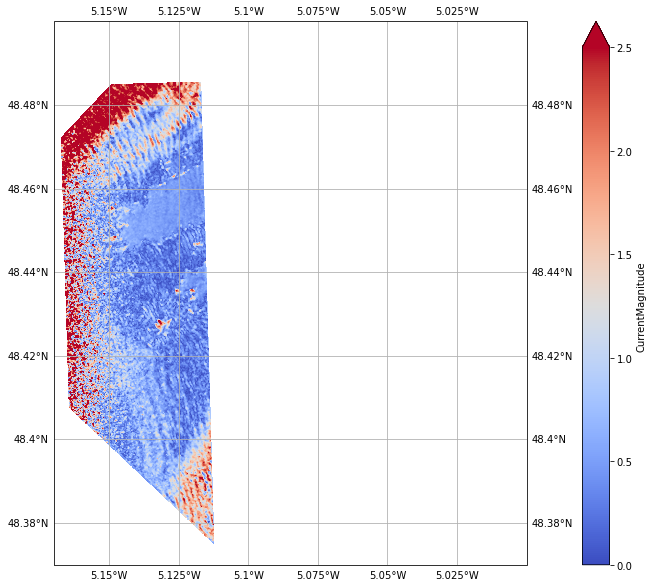

In [5]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
dsl2.CurrentMagnitude.plot(
                                 y='latitude', x='longitude',
                                 robust=True, 
                                 cmap='coolwarm',
                                 vmin=0, vmax=2.5,
                                       transform=ccrs.PlateCarree()
                                           )
gl=ax.gridlines(draw_labels=True)
ax.set_extent([-5.17, -5., 48.37, 48.5], crs=ccrs.PlateCarree())

In [ ]:
def compute_current_vectors(level2):
    
    level2['CurrentVectorUComponent']=level2.CurrentMagnitude *np.cos(np.radians(level2.CurrentDirection))
    level2['CurrentVectorVComponent']=level2.CurrentMagnitude *np.sin(np.radians(level2.CurrentDirection))
    
    return level2

In [ ]:
dsl2 = compute_current_vectors(dsl2)

In [ ]:
dsl2.latitude

In [ ]:
vector_density=30
#X, Y = np.meshgrid(dsl2.longitude, dsl2.latitude, indexing='ij')
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
dsl2.CurrentMagnitude.plot(
                                 y='latitude', x='longitude',
                                 robust=True, 
                                 cmap='coolwarm',
                                 vmin=0, vmax=2.5,
                                       transform=ccrs.PlateCarree()
                                           )
gl=ax.gridlines(draw_labels=True)
ax.set_extent([-5.17, -5., 48.37, 48.5], crs=ccrs.PlateCarree())

plt.quiver(dsl2.latitude[::vector_density, ::vector_density],
               dsl2.longitude[::vector_density, ::vector_density],
               dsl2.CurrentVectorUComponent[::vector_density, ::vector_density],
               dsl2.CurrentVectorVComponent[::vector_density, ::vector_density])

In [34]:
dsl2

<xarray.Dataset>
Dimensions:                (CrossRange: 1572, GroundRange: 474)
Coordinates:
  * CrossRange             (CrossRange) float64 -7.56e+03 ... 5.008e+03
  * GroundRange            (GroundRange) float64 1.04e+03 ... 4.824e+03
    longitude              (CrossRange, GroundRange) float64 -5.112 ... -5.168
    latitude               (CrossRange, GroundRange) float64 48.37 ... 48.48
Data variables:
    CurrentMagnitude       (CrossRange, GroundRange) float64 nan nan ... nan nan
    CurrentDirection       (CrossRange, GroundRange) float64 nan nan ... nan nan
    U_xband                (CrossRange, GroundRange) float64 nan nan ... nan nan
    V_xband                (CrossRange, GroundRange) float64 nan nan ... nan nan
    XBandCurrentMagnitude  (CrossRange, GroundRange) float64 nan nan ... nan nan

In [35]:
#x_band_file="D:\data\SEASTAR\SEASTARex\Data\Hereon\Xband_radar_17th_may.mat"
x_band_file="D:\data\oscar\Hereon\Xband_radar_17th_may.mat"
ds_xband=loadmat(x_band_file)
dsl2['U_xband'] = xr.DataArray(data=interpolate.griddata(points=(np.ravel(ds_xband['longitude']),
                                                                 np.ravel(ds_xband['latitude'])),
                                                         values=(np.ravel(ds_xband['Ux'])),
                                                         xi=(dsl2.longitude.values,
                                                             dsl2.latitude.values)
                                                        ),
                              dims=dsl2.dims,
                              coords=dsl2.coords
                              )
dsl2['V_xband'] = xr.DataArray(data=interpolate.griddata(points=(np.ravel(ds_xband['longitude']),
                                                                 np.ravel(ds_xband['latitude'])),
                                                         values=(np.ravel(ds_xband['Uy'])),
                                                         xi=(dsl2.longitude.values,
                                                             dsl2.latitude.values)
                                                        ),
                              dims=dsl2.dims,
                              coords=dsl2.coords
                              )
dsl2['XBandCurrentMagnitude'] = np.sqrt(dsl2.U_xband ** 2 + dsl2.V_xband ** 2)



In [46]:
dsl1.coords['longitude']=dsl1.LonImage
dsl1.coords['latitude']=dsl1.LatImage


<xarray.Dataset>
Dimensions:                                 (CrossRange: 1572, GroundRange: 474, Antenna: 2, GPSTime: 1297800, AntPatternAngles: 201, ModelTransformationTagCols: 4, ModelTransformationTagRows: 4)
Coordinates:
  * CrossRange                              (CrossRange) float64 -7.56e+03 .....
  * GroundRange                             (GroundRange) float64 1.04e+03 .....
  * GPSTime                                 (GPSTime) float64 2.072e+05 ... 2...
  * AntPatternAngles                        (AntPatternAngles) float64 -90.0 ...
  * Antenna                                 (Antenna) <U4 'Fore' 'Aft'
    longitude                               (Antenna, CrossRange, GroundRange) float64 ...
    latitude                                (Antenna, CrossRange, GroundRange) float64 ...
Dimensions without coordinates: ModelTransformationTagCols, ModelTransformationTagRows
Data variables: (12/105)
    CalImage                                (CrossRange, GroundRange) float32 ...
    SigmaImageSingleLookRealPart            (Antenna, CrossRange, GroundRange) float64 ...
    SigmaImageSingleLookImaginaryPart       (Antenna, CrossRange, GroundRange) float64 ...
    LatImage                                (Antenna, CrossRange, GroundRange) float64 ...
    LonImage                                (Antenna, CrossRange, GroundRange) float64 ...
    DEMImage                                (Antenna, CrossRange, GroundRange) float32 ...
    ...                                      ...
    TimeLag                                 (Antenna, CrossRange, GroundRange) float64 ...
    CentralWavenumber                       (Antenna) float64 282.9 282.9
    IncidenceAngleImage                     (Antenna, CrossRange, GroundRange) float64 ...
    RadialSurfaceVelocity                   (Antenna, CrossRange, GroundRange) float64 ...
    Polarization                            (Antenna) <U2 'VV' 'VV'
    RadialSurfaceCurrent                    (Antenna, CrossRange, GroundRange) float64 ...
Attributes:
    Title:     Track : 20220517T093239
    Source:    MetaSensing Airborne SAR
    History:   12-Oct-2022 17:44:33 File Generation
    Comments:  /media/Y/BREST_PROJECT/20220517T093239

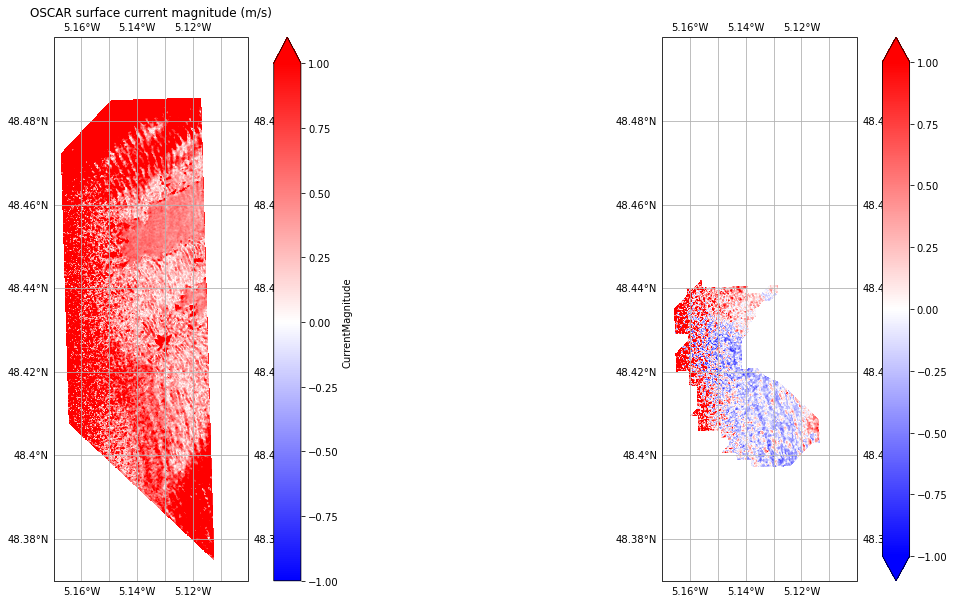

In [129]:
CurrentDiff = dsl2.CurrentMagnitude - dsl2.XBandCurrentMagnitude

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,2,1, projection=ccrs.Mercator())

dsl2.CurrentMagnitude.plot(y='latitude', x='longitude',
                 robust=True, 
                 cmap='bwr',
                 vmin=-1, vmax=1,
                 transform=ccrs.PlateCarree(),
                 #add_colorbar=False
                )
plt.title('OSCAR surface current magnitude (m/s)')
ax2 = fig.add_subplot(1,2,2, projection=ccrs.Mercator())
(dsl2.CurrentMagnitude - dsl2.XBandCurrentMagnitude).plot(y='latitude', x='longitude',
                 robust=True, 
                 cmap='bwr',
                 vmin=-1, vmax=1,
                 transform=ccrs.PlateCarree(),
                 #add_colorbar=False
                )
gl=ax.gridlines(draw_labels=True)
ax.set_extent([-5.17, -5.1, 48.37, 48.5], crs=ccrs.PlateCarree())

gl=ax2.gridlines(draw_labels=True)
ax2.set_extent([-5.17, -5.1, 48.37, 48.5], crs=ccrs.PlateCarree())

AttributeError: 'AxesSubplot' object has no property 'figsize'

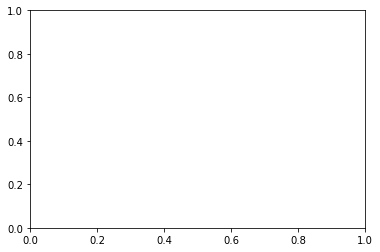

In [121]:
fig = plt.figure(figsize=(10, 10))
plt.hexbin(
    x=dsl2.XBandCurrentMagnitude.values.flatten(), 
    y=dsl2.CurrentMagnitude.values.flatten(),
    gridsize=100,
    cmap='gist_yarg',
)

plt.xlim([0,2])
plt.ylim([0,2])
plt.plot([0,2],[0,2],'k')
#plt.axis('equal')
plt.title('Derived surface currents')
plt.xlabel('X-band derived surface current (m/s)')
plt.ylabel('OSCAR surface current (m/s)')
ax.set(xticklabels=[])

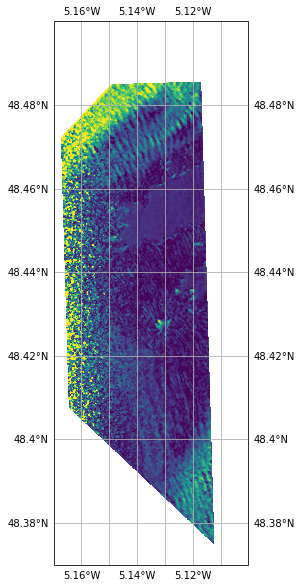

In [123]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
dsl2.CurrentMagnitude.plot(
                                 y='latitude', x='longitude',
                                 robust=True, 
                                 #cmap='hot',
                     add_colorbar=False,
                                       transform=ccrs.PlateCarree()
                                           )
gl=ax.gridlines(draw_labels=True)
ax.set_extent([-5.17, -5.1, 48.37, 48.5], crs=ccrs.PlateCarree())

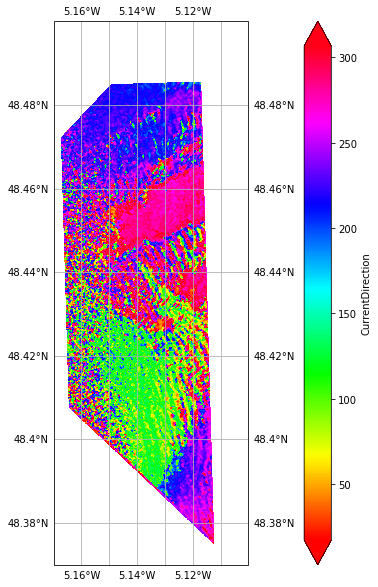

In [98]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
dsl2.CurrentDirection.plot(
                                 y='latitude', x='longitude',
                                 robust=True, 
                                 cmap='hsv',
                                       transform=ccrs.PlateCarree()
                                           )
gl=ax.gridlines(draw_labels=True)
ax.set_extent([-5.17, -5.1, 48.37, 48.5], crs=ccrs.PlateCarree())

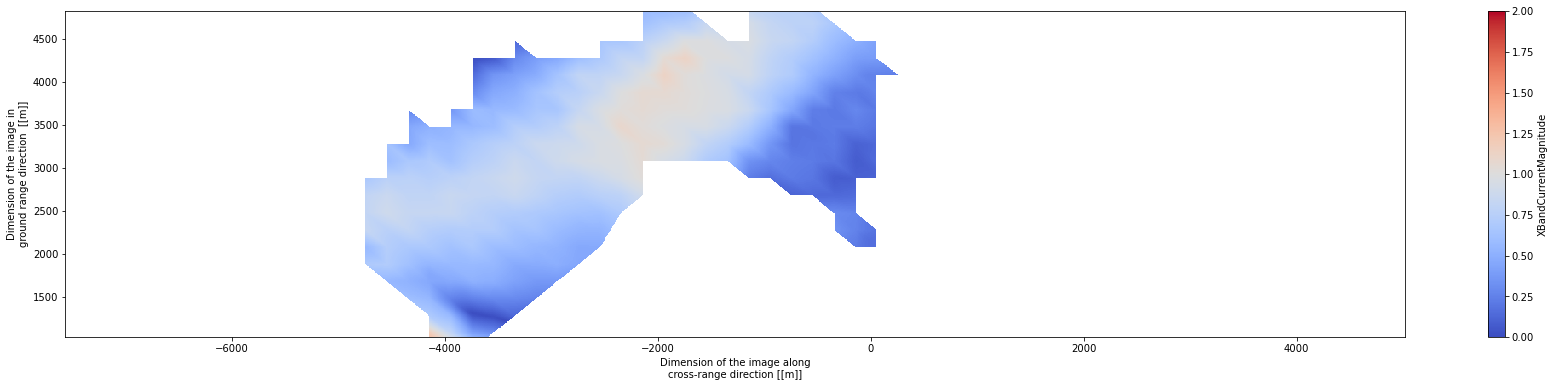

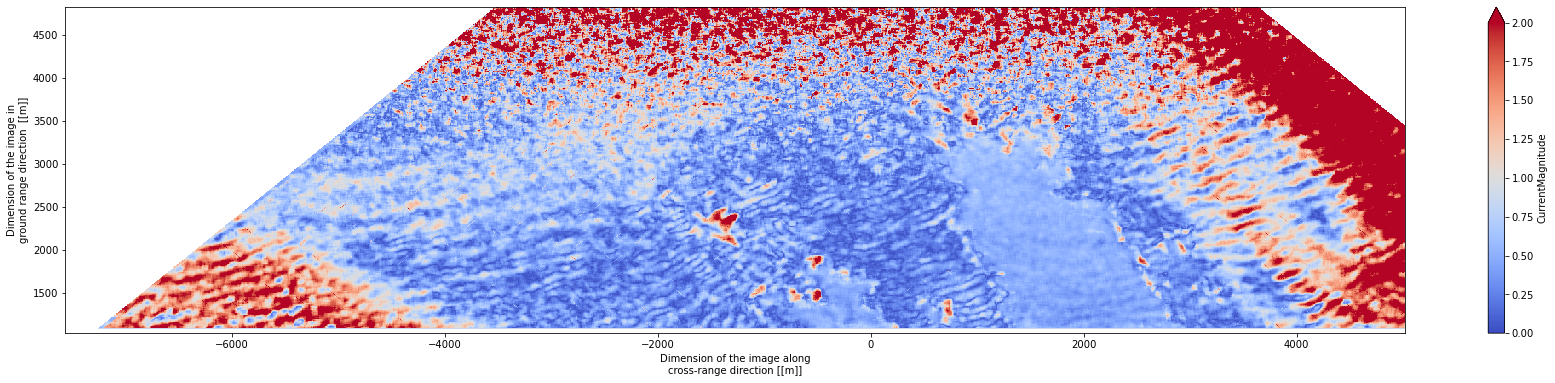

In [134]:
ax1 = dsl2.XBandCurrentMagnitude.plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='coolwarm',
                                                        vmin=0,vmax=2
                      )
ax2 = dsl2.CurrentMagnitude.plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='coolwarm',
                                                        vmin=0,vmax=2
                      )